In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve
from sklearn.svm import SVC

In [67]:
df=pd.read_csv(r"diabetes.csv")

In [68]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [69]:
def grab_col_names(dataframe,cat_th=20,car_th=30):
    cat_var=[col for col in dataframe.columns if dataframe[col].dtype=="O"]
    num_but_cat=[col for col in dataframe.columns if dataframe[col].dtype!="O"
                 and dataframe[col].nunique()<cat_th]
    cat_but_car=[col for col in dataframe.columns if dataframe[col].dtype=="O"
                 and dataframe[col].nunique()>car_th]
    cat_var=cat_var+num_but_cat
    cat_var=[col for col in cat_var if col not in cat_but_car]

    #numeric variable
    num_var=[col for col in dataframe.columns if dataframe[col].dtype!="O"]
    num_var=[col for col in num_var if col not in num_but_cat]

    print(f"Observations {dataframe.shape[0]}")
    print(f"Feature count {dataframe.shape[1]}")
    print(f"Categoric variable {len(cat_var)}")
    print(f"Numeric variable {len(num_var)}")
    print(f"Cardinal variable {len(cat_but_car)}")
    return cat_var,num_var,cat_but_car

In [70]:
cat,num,car=grab_col_names(df)

Observations 768
Feature count 9
Categoric variable 2
Numeric variable 7
Cardinal variable 0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [72]:
cat

['Pregnancies', 'Outcome']

In [73]:
def relation_analyser(dataframe,target):
    for col in dataframe.columns:
        print(dataframe.groupby(col).agg({target:["mean","count"]}))

In [74]:
relation_analyser(df,"Outcome")

              Outcome      
                 mean count
Pregnancies                
0            0.342342   111
1            0.214815   135
2            0.184466   103
3            0.360000    75
4            0.338235    68
5            0.368421    57
6            0.320000    50
7            0.555556    45
8            0.578947    38
9            0.642857    28
10           0.416667    24
11           0.636364    11
12           0.444444     9
13           0.500000    10
14           1.000000     2
15           1.000000     1
17           1.000000     1
        Outcome      
           mean count
Glucose              
0          0.40     5
44         0.00     1
56         0.00     1
57         0.00     2
61         0.00     1
...         ...   ...
195        1.00     2
196        1.00     3
197        0.75     4
198        1.00     1
199        1.00     1

[136 rows x 2 columns]
                Outcome      
                   mean count
BloodPressure                
0              0.4

In [75]:
df = df.apply(lambda col: col if col.name in ["Pregnancies", "Outcome"] else col.where(col != 0, np.nan), axis=0)

In [76]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


In [77]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [78]:
df.loc[df["Outcome"]==0,"Insulin"].mean()

130.28787878787878

In [79]:
df["Insulin"]=df["Insulin"].fillna(df.loc[df["Outcome"]==1,"Insulin"].mean())
df["Insulin"]=df["Insulin"].fillna(df.loc[df["Outcome"]==0,"Insulin"].mean())

In [80]:
df["Insulin"].isnull().sum()

0

In [81]:
df.loc[df["Outcome"]==1,"SkinThickness"].mean()

33.0

In [82]:
df.loc[df["Outcome"]==0,"SkinThickness"].mean()

27.235457063711912

In [83]:
df["SkinThickness"]=df["SkinThickness"].fillna(df.loc[df["Outcome"]==0,"SkinThickness"].mean())
df["SkinThickness"]=df["SkinThickness"].fillna(df.loc[df["Outcome"]==1,"SkinThickness"].mean())


In [84]:
df.loc[df["Outcome"]==1,"BloodPressure"].mean()

75.32142857142857

In [85]:
df.loc[df["Outcome"]==0,"BloodPressure"].mean()

70.87733887733887

In [86]:
df["BloodPressure"]=df["BloodPressure"].fillna(df.loc[df["Outcome"]==0,"BloodPressure"].mean())
df["BloodPressure"]=df["BloodPressure"].fillna(df.loc[df["Outcome"]==1,"BloodPressure"].mean())

In [87]:
df.loc[df["Outcome"]==0,"BMI"].mean()

30.859674134419553

In [88]:
df.loc[df["Outcome"]==1,"BMI"].mean()

35.40676691729323

In [89]:
df["BMI"]=df["BMI"].fillna(df.loc[df["Outcome"]==1,"BMI"].mean())
df["BMI"]=df["BMI"].fillna(df.loc[df["Outcome"]==0,"BMI"].mean())

In [90]:
df.isnull().sum()

Pregnancies                 0
Glucose                     5
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [91]:
df["Glucose"]=df["Glucose"].fillna(df.loc[df["Outcome"]==1,"Glucose"].mean())
df["Glucose"]=df["Glucose"].fillna(df.loc[df["Outcome"]==0,"Glucose"].mean())

In [92]:
#Lets view features and make new features 
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,206.846154,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,206.846154,26.6,0.351,31,0
2,8,183.0,64.0,27.235457,206.846154,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [93]:
# df.loc[(df["Pregnancies"] >= 0) & (df["Pregnancies"] < 3), "New_Pregnancy_Feature"] = "Young_female"
# df.loc[(df["Pregnancies"] >= 3) & (df["Pregnancies"] < 6), "New_Pregnancy_Feature"] = "Adult_female"
# df.loc[(df["Pregnancies"] >= 6) & (df["Pregnancies"] < 10), "New_Pregnancy_Feature"] = "Mature_female"
# df.loc[df["Pregnancies"] >= 10, "New_Pregnancy_Feature"] = "Most_older_female"

In [94]:
# Handling Outlier Values
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,206.846154,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,206.846154,26.6,0.351,31,0
2,8,183.0,64.0,27.235457,206.846154,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [95]:
df["Age"].min()

21

In [96]:
df["Age"].max()

81

In [97]:
df.loc[(df["Age"] >= 21) & (df["Age"] <= 30), "Age_category"] = "Young_female"
df.loc[(df["Age"] >= 31) & (df["Age"] <= 60), "Age_category"] = "Adult_female"
df.loc[df["Age"] >= 61, "Age_category"] = "Mature_female"

In [98]:

cat,num,car=grab_col_names(df)

Observations 768
Feature count 10
Categoric variable 3
Numeric variable 7
Cardinal variable 0


In [99]:
cat

['Age_category', 'Pregnancies', 'Outcome']

In [100]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_category
0,6,148.0,72.0,35.000000,206.846154,33.6,0.627,50,1,Adult_female
1,1,85.0,66.0,29.000000,206.846154,26.6,0.351,31,0,Adult_female
2,8,183.0,64.0,27.235457,206.846154,23.3,0.672,32,1,Adult_female
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0,Young_female
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1,Adult_female


In [101]:
df.groupby("Pregnancies").agg({"BMI":["mean","count"]})

BMI      
                  mean count
Pregnancies                 
0            35.247030   111
1            31.372593   135
2            31.271005   103
3            30.897424    75
4            32.141176    68
5            33.814154    57
6            30.998135    50
7            33.417928    45
8            32.500178    38
9            31.707143    28
10           32.116949    24
11           38.563636    11
12           32.344444     9
13           35.000000    10
14           35.100000     2
15           37.100000     1
17           40.900000     1

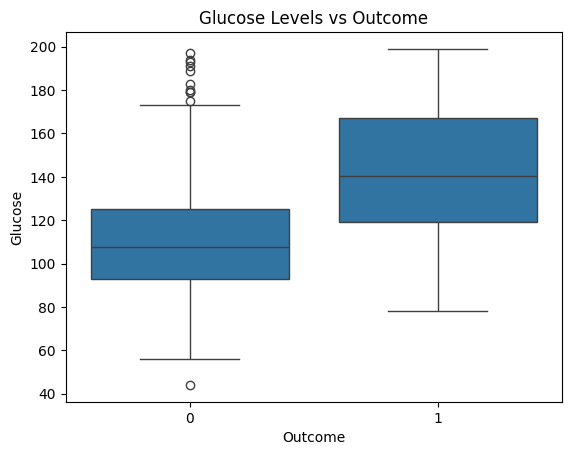

In [102]:
sns.boxplot(x=df["Outcome"], y=df["Glucose"])
plt.title("Glucose Levels vs Outcome")
plt.show()

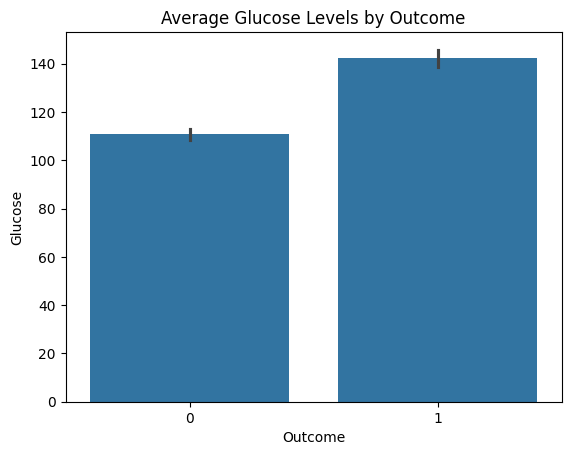

In [103]:
sns.barplot(x=df["Outcome"], y=df["Glucose"])
plt.title("Average Glucose Levels by Outcome")
plt.show()

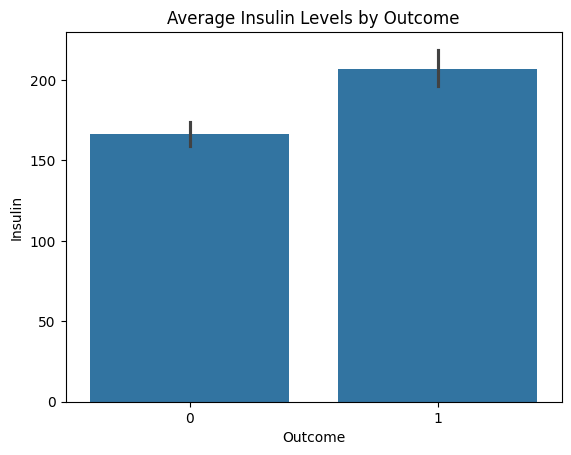

In [104]:
sns.barplot(x=df["Outcome"], y=df["Insulin"])
plt.title("Average Insulin Levels by Outcome")
plt.show()

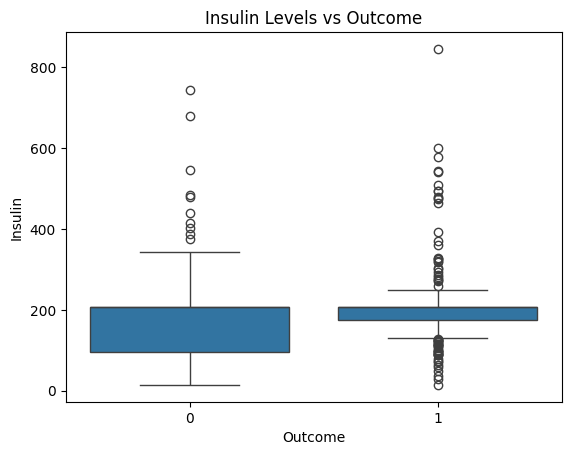

In [105]:
sns.boxplot(x=df["Outcome"], y=df["Insulin"])
plt.title("Insulin Levels vs Outcome")
plt.show()

In [106]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Age_category'],
      dtype='object')

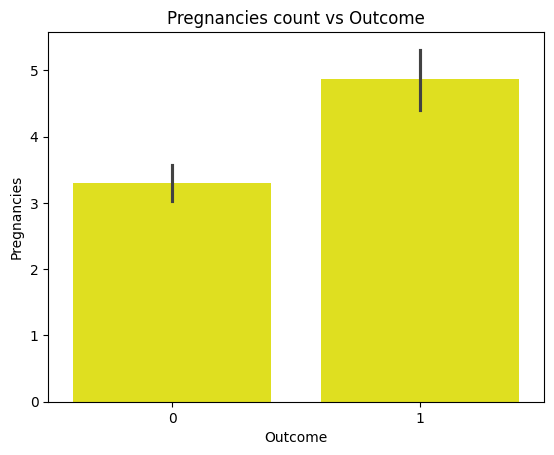

In [107]:
sns.barplot(x=df["Outcome"],y=df["Pregnancies"],color="yellow")
plt.title("Pregnancies count vs Outcome")
plt.show()

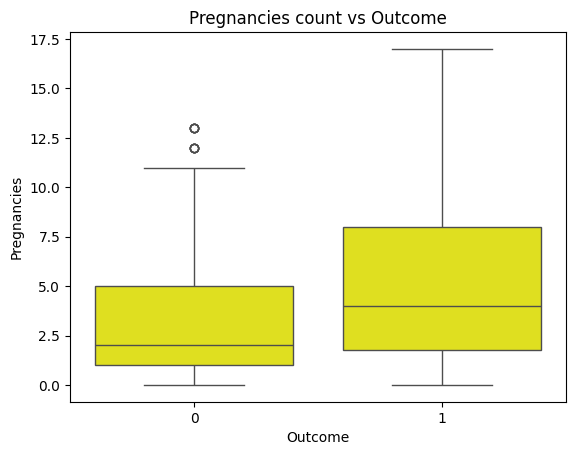

In [108]:
sns.boxplot(x=df["Outcome"],y=df["Pregnancies"],color="yellow")
plt.title("Pregnancies count vs Outcome")
plt.show()

In [109]:
#Outlier detection
def outlier_trasholder(dataframe,quantile1=0.25,quantile2=0.75,index=False):
    limits=[]
    outlier_index_list=[]
    for col in dataframe.columns:
        q1=dataframe[col].quantile(quantile1)
        q3=dataframe[col].quantile(quantile2)
        iqr=q3-q1
        lower_limit=q1-iqr*1.5
        upper_limit=q3+iqr*1.5
        limits.append({"column": col, "lower_limit": lower_limit, "upper_limit": upper_limit})
        if (dataframe[(dataframe[col]<lower_limit) | (dataframe[col]>upper_limit)]).any(axis=None) :
            print(f"Outlier mevcut kolon adı:{col}")
            if index:
                    outlier_index = dataframe[(dataframe[col] < lower_limit) | (dataframe[col] > upper_limit)].index
                    outlier_index_list.extend(outlier_index)
        else:
            print(f"Outlier yok kolon adı:{col}")
        
    if index:  
        return limits, list(set(outlier_index_list))  
    else:
        return limits

In [110]:
cat,num,car=grab_col_names(df)

Observations 768
Feature count 10
Categoric variable 3
Numeric variable 7
Cardinal variable 0


In [111]:
limits,indexs=outlier_trasholder(df[num],quantile1=0.5,quantile2=0.95,index=True)

Outlier yok kolon adı:Glucose
Outlier mevcut kolon adı:BloodPressure
Outlier mevcut kolon adı:SkinThickness
Outlier mevcut kolon adı:Insulin
Outlier mevcut kolon adı:BMI
Outlier mevcut kolon adı:DiabetesPedigreeFunction
Outlier yok kolon adı:Age


In [112]:
pd.Series(indexs) #Length: 129

0        4
1        8
2      520
3       13
4       18
      ... 
124    486
125    490
126    497
127    500
128    508
Length: 129, dtype: int64

In [113]:
clf=LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df[num])
df_scores=clf.negative_outlier_factor_

In [114]:
df_scores[0:10]

array([-1.03987184, -0.98748246, -1.06689322, -0.98490818, -1.1974163 ,
       -0.95725191, -1.09164468, -0.97190421, -1.24110494, -1.1640364 ])

In [115]:
np.sort(df_scores)[0:10]

array([-2.93283107, -2.86604953, -2.59790993, -2.50622114, -2.32611766,
       -2.12349996, -2.04564033, -1.99078446, -1.89812118, -1.83508749])

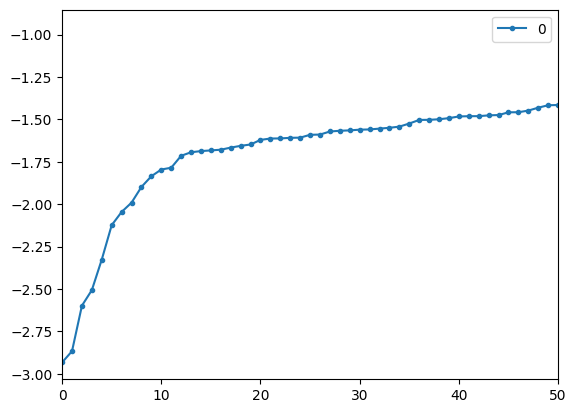

In [116]:
scores=pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True,xlim=[0,50],style=".-")
plt.show()

In [117]:
th=np.sort(df_scores)[5]

In [118]:
th

-2.1234999614027865

In [119]:
df[df_scores<th].index

Index([13, 254, 445, 579, 679], dtype='int64')

In [120]:
df[df_scores<th]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_category
13,1,189.0,60.0,23.0,846.000000,30.1,0.398,59,1,Adult_female
254,12,92.0,62.0,7.0,258.000000,27.6,0.926,44,1,Adult_female
445,0,180.0,78.0,63.0,14.000000,59.4,2.420,25,1,Young_female
579,2,197.0,70.0,99.0,206.846154,34.7,0.575,62,1,Mature_female
679,2,101.0,58.0,17.0,265.000000,24.2,0.614,23,0,Young_female


In [121]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.821091,72.335556,28.586522,180.529247,32.499706,0.471876,33.240885,0.348958
std,3.369578,30.481209,12.100548,8.834454,88.808047,6.884088,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,27.235457,206.846154,32.400000,0.372500,29.000000,0.000000
75%,6.000000,141.250000,80.000000,32.000000,206.846154,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [122]:
df=df.drop([13, 254, 445, 579, 679],axis=0)

In [123]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Age_category'],
      dtype='object')

In [130]:

age_dummies = pd.get_dummies(df["Age_category"], drop_first=True, dtype=int)


df = pd.concat([df, age_dummies], axis=1)

df = df.drop("Age_category", axis=1)

In [131]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Mature_female,Young_female
0,6,148.0,72.0,35.000000,206.846154,33.6,0.627,50,1,0,0
1,1,85.0,66.0,29.000000,206.846154,26.6,0.351,31,0,0,0
2,8,183.0,64.0,27.235457,206.846154,23.3,0.672,32,1,0,0
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0,0,1
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.000000,180.000000,32.9,0.171,63,0,1,0
764,2,122.0,70.0,27.000000,206.846154,36.8,0.340,27,0,0,1
765,5,121.0,72.0,23.000000,112.000000,26.2,0.245,30,0,0,1
766,1,126.0,60.0,27.235457,206.846154,30.1,0.349,47,1,0,0


In [159]:

x = df.drop("Outcome", axis=1).values
y = df["Outcome"]
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0)


scaler = StandardScaler()
shaped_x_train = scaler.fit_transform(X_train)
shaped_x_test = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(shaped_x_train, Y_train)



Y_head = lr.predict(shaped_x_test)

svc=SVC(kernel="linear")
svc.fit(shaped_x_train, Y_train)
Y_head2=svc.predict(shaped_x_test)

In [160]:
# Karışıklık matrisi
conf = confusion_matrix(Y_test, Y_head)
print(f"Karışıklık matrisine göre sonuç:\n{conf}")

# Doğruluk oranı
accuracy = accuracy_score(Y_test, Y_head)
print(f"Model başarı oranı: {accuracy}")


Karışıklık matrisine göre sonuç:
[[90 14]
 [23 26]]
Model başarı oranı: 0.7581699346405228


In [161]:
conf = confusion_matrix(Y_test, Y_head2)
print(f"Karışıklık matrisine göre sonuç:\n{conf}")

# Doğruluk oranı
accuracy = accuracy_score(Y_test, Y_head2)
print(f"Model başarı oranı: {accuracy}")


Karışıklık matrisine göre sonuç:
[[93 11]
 [24 25]]
Model başarı oranı: 0.7712418300653595
